# Import and Install Necessary Libraries

In [ ]:
#!pip install
#!pip install timm
!pip install torchmetrics

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu

In [2]:
import torch
import h5py
import random
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_file_from_google_drive, _decompress

In [3]:
from tqdm import tqdm
import torch.nn.functional as F

In [5]:
from urllib.request import urlopen
from PIL import Image
import timm

In [6]:
from transformers import AutoImageProcessor, AutoModel

# Data Processing

**Connect to the drive to import the dataset files**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
IMAGES_PATH ="drive/MyDrive/camelyonpatch_level_2_split_valid_x.h5"
LABELS_PATH ="drive/MyDrive/camelyonpatch_level_2_split_valid_y.h5"

In [21]:
images = np.array(h5py.File(IMAGES_PATH)['x'])
labels = np.array([y.item() for y in h5py.File(LABELS_PATH)['y']])

In [22]:
def get_split_indices(dataset_length, train_ratio=0.8):
    """
    Function which splits the data into tranining and validation sets.
    arguments:
        dataset_length [int]: number of elements in the dataset
        train_ratio [float]: ratio of the dataset in the training set
    returns:
        train_indices [list]: list of indices in the training set (of size dataset_length*train_ratio)
        val_indices [list]: list of indices in the validation set (of size dataset_length*(1-train_ratio))
    """

    indices = np.arange(dataset_length)
    np.random.shuffle(indices)
    train_size = int(train_ratio * dataset_length)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    return train_indices,val_indices

In [23]:
train_indices, val_indices = get_split_indices(len(labels))

**Define the Patchcam Custom Dataset Class**

In [24]:
class PCAMDataset(Dataset):
    def __init__(self, data, labels, train):
        """
        Dataset class for the PCAM dataset.
        arguments:
            data [numpy.array]: all RGB 96-96 images
            labels [numpy.array]: corresponding labels
            train [bool]: whether the dataset is training or validation
        """
        super(PCAMDataset, self).__init__()
        self.data = data
        self.labels = labels
        self.train = train

        if self.train:

            self.augmentation = transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.4),transforms.RandomRotation(20)])
        else:
            self.augmentation=transforms.Compose([transforms.ToTensor()])


    def __len__(self):

        return(len(self.labels))


    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        image=self.data[idx]
        label=self.labels[idx]
        image = self.augmentation(image)
        return(image,label)


In [25]:
BATCH_SIZE =32
train_dataset = PCAMDataset(images[train_indices], labels[train_indices], train=True)
val_dataset = PCAMDataset(images[val_indices], labels[val_indices], train=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Train the UNeT Model

**Helper Functions**

In [ ]:
def write_results(save_folder, epoch, train_acc, val_acc, train_loss, val_loss):
    with open('{}/progress.txt'.format(save_folder),'a') as ff:
      ff.write(' E: ')
      ff.write(str(epoch))
      ff.write('         ')
      ff.write(' TRAIN_OA: ')
      ff.write(str('%.3f' % train_acc))
      ff.write(' VAL_OA: ')
      ff.write(str('%.3f' % val_acc))
      ff.write('         ')
      ff.write(' TRAIN_LOSS: ')
      ff.write(str('%.3f' % train_loss))
      ff.write(' VAL_LOSS: ')
      ff.write(str('%.3f' % val_loss))
      ff.write('\n')

In [ ]:
import matplotlib.pyplot as plt
def save_graph(train_loss, val_loss, nb_epochs, save_folder):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('{}/chart.png'.format(save_folder))

**Training loop**

In [ ]:
def training(model,optimizer,num_epochs,batchsize):
  total_train_losses = []
  total_val_losses = []
  val_accs=[]
  for epoch in range(1,num_epochs+1):
      ##TRAINING##
      model.train()
      train_losses = []
      trn_lbl = torch.Tensor([])
      trn_preds = torch.Tensor([])


      for i, batch, in enumerate(tqdm(train_dataloader)):
              img_batch, lbl_batch = batch
              trn_lbl=torch.cat((trn_lbl, lbl_batch))
              img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)

              optimizer.zero_grad()
              logits = model(img_batch)
              trn_preds=torch.cat((trn_preds, logits.argmax(1).cpu()))
              loss=criterion(logits, lbl_batch)
              loss.backward()
              optimizer.step()
              train_losses.append(loss.item())

      train_acc=metric(trn_preds, trn_lbl)
      train_loss_mean = np.mean(train_losses)
      total_train_losses.append(train_loss_mean)

      ##VALIDATION##
      model.eval()
      val_losses = []
      val_losses = []
      val_lbl = torch.Tensor([])
      val_preds = torch.Tensor([])
      with torch.no_grad():
        for i, batch, in enumerate(tqdm(val_dataloader)):
                  img_batch, lbl_batch = batch
                  val_lbl=torch.cat((val_lbl, lbl_batch))
                  img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)

                  logits=model(img_batch)
                  val_preds=torch.cat((val_preds, logits.argmax(1).cpu()))
                  loss=criterion(logits, lbl_batch)
                  val_losses.append(loss.item())

        val_acc=metric(val_preds, val_lbl)
        val_loss_mean = np.mean(val_losses)
        total_val_losses.append(val_loss_mean)
        val_accs.append(float(val_acc))

      print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
      print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)

      write_results(save_folder, epoch, train_acc, val_acc, train_loss_mean, val_loss_mean)

      torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))
  return(val_acc,train_acc,total_train_losses,total_val_losses,val_accs)



In [ ]:
save_folder = 'drive/MyDrive/Assignment/Models' #Define the save folder where to save the model

**Import pretrained segmentation UNeT**

In [15]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


**Add classification head and freez original layers for retraining**

In [16]:
class ModifiedModel(nn.Module):
    def __init__(self, original_model):
        super(ModifiedModel, self).__init__()
        # Extract the layers from the original model except the last layer
        self.features = nn.Sequential(*list(original_model.children())[:10])
        # Add a Linear layer
        self.linear = nn.Linear(36864, 2)  # Assuming num_classes is the number of output classes
        # Add softmax
        self.softmax = nn.Softmax(dim=1)

        # Freeze all layers except the linear and softmax layers
        self.freeze_layers()

    def freeze_layers(self):
        for param in self.features.parameters():
            param.requires_grad = False

    def unfreeze_linear_softmax_layers(self):
        for param in self.linear.parameters():
            param.requires_grad = True
        for param in self.softmax.parameters():
            param.requires_grad = True

    def forward(self, x):
        # Forward pass through the features
        x = self.features(x)
        # Reshape the tensor to be suitable for Linear layer input
        x = x.view(x.size(0), -1)
        # Pass through the Linear layer
        x = self.linear(x)
        # Apply softmax
        x = self.softmax(x)
        return x

# Create an instance of the modified model
newmodel = ModifiedModel(model)


In [18]:
newmodel.load_state_dict(torch.load("drive/MyDrive/Assignment/Models/model_3.pt"))

<All keys matched successfully>

**Training parameters**

In [29]:
from torchmetrics.classification import BinaryAccuracy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr =0.01
num_epochs =3
optimizer =torch.optim.SGD(newmodel.parameters(),lr)
criterion =nn.CrossEntropyLoss()
metric = BinaryAccuracy()

In [ ]:
val_acc,train_acc,total_train_losses,total_val_losses,val_accs=training(newmodel,optimizer,num_epochs,BATCH_SIZE)

100%|██████████| 205/205 [03:41<00:00,  1.08s/it]


TRAIN_LOSS:  0.519 TRAIN_ACC:  0.782
VAL_LOSS:  0.517 VAL_ACC:  0.782


100%|██████████| 205/205 [03:42<00:00,  1.09s/it]


TRAIN_LOSS:  0.515 TRAIN_ACC:  0.788
VAL_LOSS:  0.538 VAL_ACC:  0.759


100%|██████████| 205/205 [03:41<00:00,  1.08s/it]


TRAIN_LOSS:  0.508 TRAIN_ACC:  0.795
VAL_LOSS:  0.498 VAL_ACC:  0.807


# CRAFT intervention for UNeT

**Split the model into two parts**

In [19]:
g = nn.Sequential(*list(newmodel.features.children())[0:4])
g.add_module('relu',nn.ReLU())
f = nn.Sequential(*list(newmodel.features.children())[4:10])


**Retrieve the images that were classed as tumerous by the model**

In [30]:
correct_images = []
newmodel.eval()
for images, labels in val_dataset:


    images = images.unsqueeze(0)
    with torch.no_grad():
        outputs = newmodel(images)
    _, predicted = torch.max(outputs, 1)

    # Compare predicted labels with ground truth labels and check if prediction is class 1
    correct_mask = torch.logical_and(predicted.eq(labels), predicted.eq(1))

    # Retain only the images with correct predictions for class 1

    correct_images.extend(images[correct_mask])
newcorrect_images=torch.stack([img for img in correct_images], 0)
newcorrect_images=newcorrect_images.to(device)

**Extract concepts**

In [34]:
from xplique.concepts import CraftTorch as Craft
from xplique.concepts import DisplayImportancesOrder

# Instanciate CRAFT
craft = Craft(input_to_latent_model = g,
              latent_to_logit_model =  f,
              number_of_concepts = 5,
              patch_size = 28,
              batch_size = 10,
              device = device)

# now we can start fit the concept using our rabbit images
# CRAFT will:
# 1. Create the patches
# 2. Find the concept (NMF Factorization)
# 3. Return the crops (crops), the embedding of the crops (crops_u),
# and the concept bank (concept_bank_w)
crops, crops_u, concept_bank_w = \
  craft.fit(newcorrect_images[:100], class_id=1)

crops.shape, crops_u.shape, concept_bank_w.shape

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


((1600, 3, 28, 28), (1600, 5), (5, 64))

**Calculate importances**

In [35]:
importances = craft.estimate_importance()

Concept 0 has an importance value of 0.04


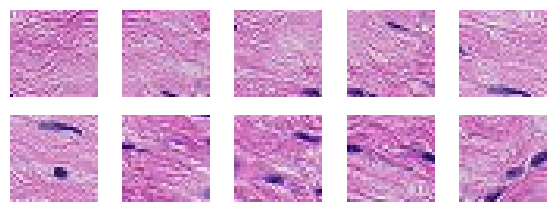

Concept 4 has an importance value of 0.04


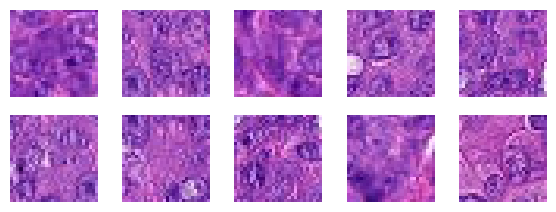

Concept 1 has an importance value of 0.01


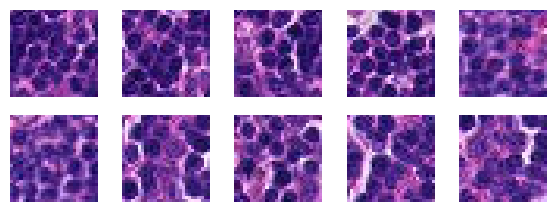

Concept 2 has an importance value of 0.01


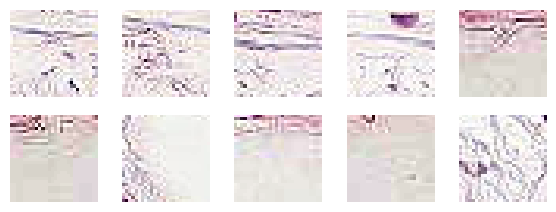

Concept 3 has an importance value of 0.01


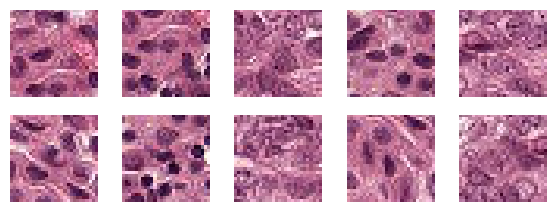

In [36]:
craft.plot_concepts_crops(nb_crops=10, nb_most_important_concepts=5,verbose=True)

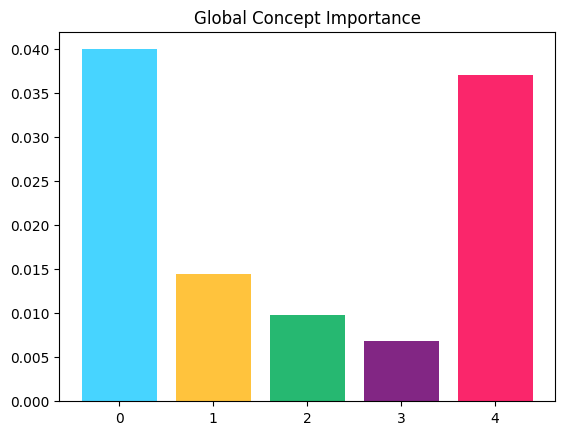

In [37]:
craft.plot_concepts_importances()

**Display all elements in one graph**

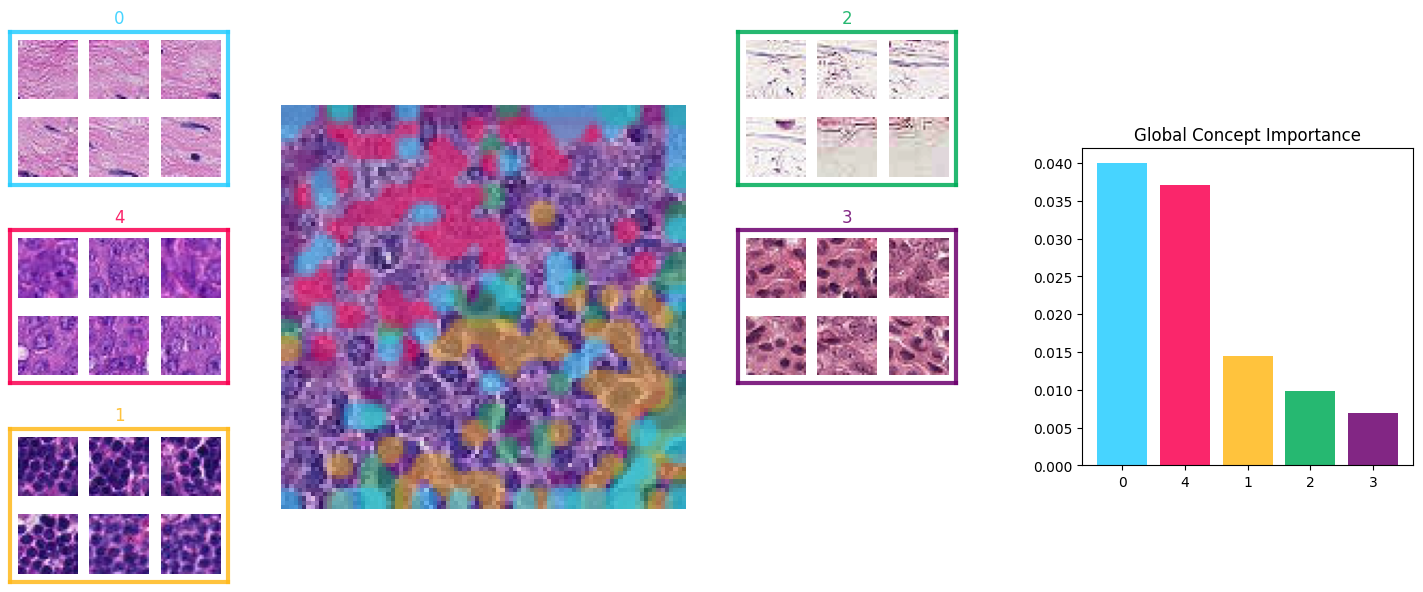

In [38]:
craft.plot_image_concepts(newcorrect_images[5])

**Show concepts in images**

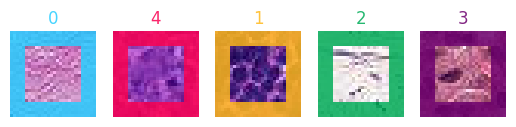

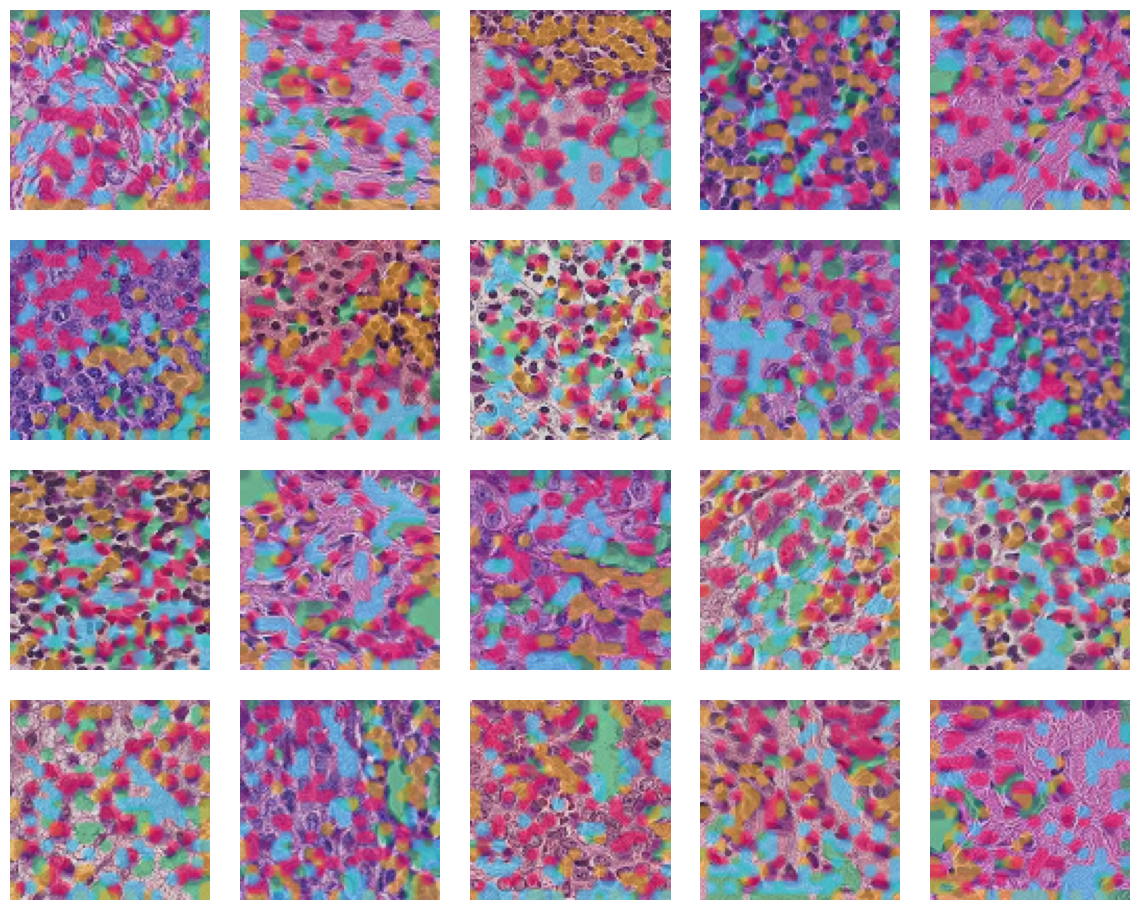

In [39]:
craft.plot_concept_attribution_maps(newcorrect_images[0:20].cpu(),
                                    nb_most_important_concepts=5)

# CRAFT intervention for ViT

**Import pretrained DINO ViT**

In [ ]:
model = timm.create_model('vit_small_patch16_224.dino', pretrained=True)

**Add classification head and retrain**

In [ ]:
class ModifiedModel(nn.Module):
    def __init__(self, original_model):
        super(ModifiedModel, self).__init__()
        # Extract the layers from the original model except the last layer
        self.features = nn.Sequential(*list(original_model.children()))
        # Add a Linear layer
        self.linear = nn.Linear(75264, 2)  # Assuming num_classes is the number of output classes
        # Add softmax
        self.softmax = nn.Softmax(dim=1)

        # Freeze all layers except the linear and softmax layers
        self.freeze_layers()

    def freeze_layers(self):
        for param in self.features.parameters():
            param.requires_grad = False

    def unfreeze_linear_softmax_layers(self):
        for param in self.linear.parameters():
            param.requires_grad = True
        for param in self.softmax.parameters():
            param.requires_grad = True

    def forward(self, x):
        # Forward pass through the features
        x = self.features(x)
        # Reshape the tensor to be suitable for Linear layer input
        x = x.view(x.size(0), -1)
        # Pass through the Linear layer
        x = self.linear(x)
        # Apply softmax
        x = self.softmax(x)
        return x



# Create an instance of the modified model
newnewmodel = ModifiedModel(model)

In [ ]:
lr =0.01
num_epochs = 1
optimizer =torch.optim.SGD(newnewmodel.parameters(),lr)
criterion =nn.CrossEntropyLoss()
metric = BinaryAccuracy()

In [ ]:
val_acc,train_acc,total_train_losses,total_val_losses,val_accs=training(newnewmodel,optimizer,num_epochs,BATCH_SIZE)

100%|██████████| 205/205 [20:44<00:00,  6.07s/it]


TRAIN_LOSS:  0.594 TRAIN_ACC:  0.717
VAL_LOSS:  0.553 VAL_ACC:  0.759


**Retrieve only positive images from the dataset**

In [ ]:
import torchvision.transforms as transforms
correct_images1 = []
for images, labels in val_dataset:
    labels = torch.tensor(labels)

    # Check if the ground truth label is 1 and create a mask
    correct_mask1 = torch.logical_and(labels == 1, torch.ones_like(labels, dtype=torch.bool))

    # Extend correct_images1 only with images where the ground truth label is 1
    correct_images1.extend(images[correct_mask1])
transforms = transforms.Compose([transforms.ToTensor(),transforms.Resize([224, 224])])
newnewcorrect_images=torch.stack([img for img in correct_images1], 0)

**Split the model into two parts**

In [ ]:
#g is the transformer
class GModel(nn.Module):
    def __init__(self, original_model):
        super(GModel, self).__init__()
        self.features = model
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.features(x)
        x = self.relu(x)
        return x

gmodel = GModel()

In [ ]:
#f is the classification head
class FModel(nn.Module):
    def __init__(self, original_model):
        super(FModel, self).__init__()
        self.linear=nn.Linear(384,2)
        self.softmax = nn.Softmax()
    def forward(self, x):
        x = self.linear(x)
        x = self.softmax(x)
        return x
fmodel = FModel(model)

In [ ]:
g = gmodel
f = fmodel

**Extract CRAFT patches**

In [ ]:
craft = Craft(input_to_latent_model = g,
              latent_to_logit_model =  f,
              number_of_concepts = 5,
              patch_size = 80,
              batch_size = 10,
              device = device,)


crops, crops_u, concept_bank_w = \
  craft.fit(newnewcorrect_images[:10], class_id=1)

crops.shape, crops_u.shape, concept_bank_w.shape

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


((90, 3, 80, 80), (90, 5), (5, 384))

**Calculate importances**

In [ ]:
importances = craft.estimate_importance()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Concept 3 has an importance value of 0.55


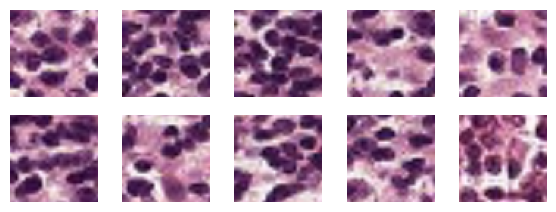

Concept 4 has an importance value of 0.25


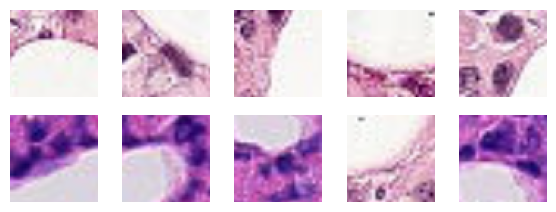

Concept 0 has an importance value of 0.22


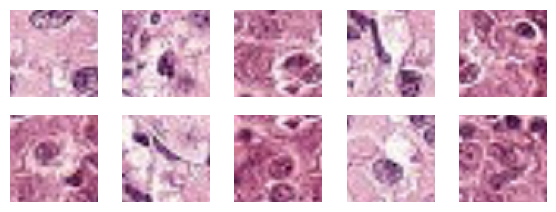

Concept 2 has an importance value of 0.00


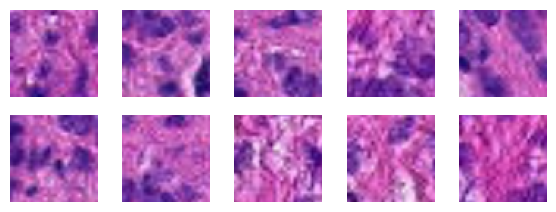

Concept 1 has an importance value of 0.00


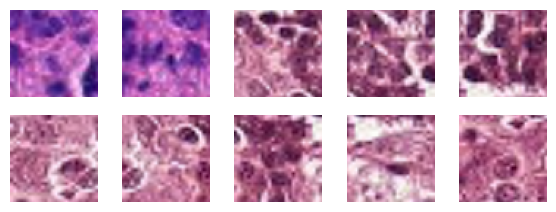

In [ ]:
craft.plot_concepts_crops(nb_crops=10, nb_most_important_concepts=5,verbose=True)

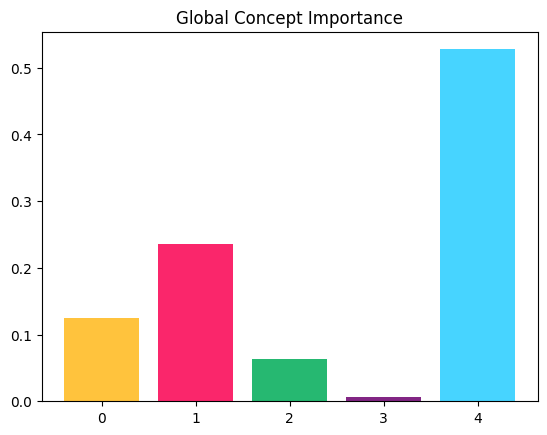

In [ ]:
craft.plot_concepts_importances()